<a href="https://colab.research.google.com/github/GaurangMangla/predictive-analytics-2-/blob/main/assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 5.22M/5.22M [00:00<00:00, 74.5MB/s]

Extracting files...


✅ Path to dataset files: /root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1
Files in Dataset Folder: ['data.csv']
✅ Using Dataset File: /root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1/data.csv
P-ARAM A: 3.00, P-BR B: 0.90
STEP 0: D Loss=1.393, G Loss=0.681
STEP 3000: D Loss=1.370, G Loss=0.668
STEP 6000: D Loss=1.384, G Loss=0.702
STEP 9000: D Loss=1.389, G Loss=0.724
STEP 12000: D Loss=1.382, G Loss=0.668


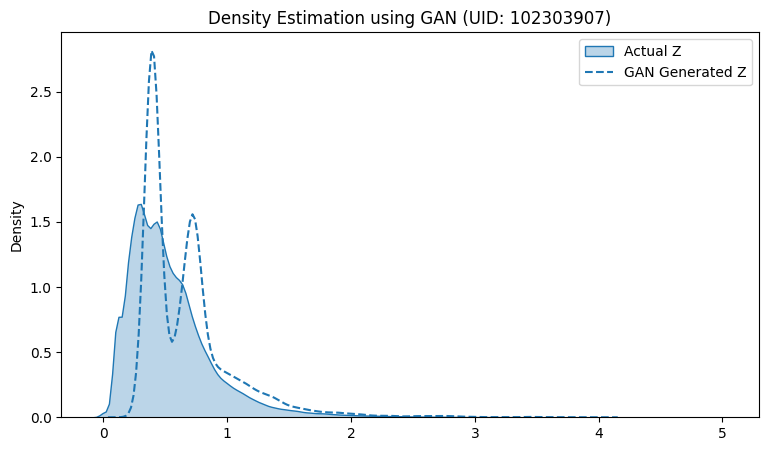

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("shrutibhargava94/india-air-quality-data")

print("✅ Path to dataset files:", path)

files = os.listdir(path)
print("Files in Dataset Folder:", files)


SRC = os.path.join(path, files[0])
print("✅ Using Dataset File:", SRC)


UID = 102303907

A_VAL = 0.5 * (UID % 7)
B_VAL = 0.3 * (UID % 5 + 1)

print(f"P-ARAM A: {A_VAL:.2f}, P-BR B: {B_VAL:.2f}")


raw_df = pd.read_csv(SRC, low_memory=False, encoding='latin-1')


if "no2" not in raw_df.columns:
    raise ValueError("❌ Column 'no2' not found in dataset!")

vec_x = pd.to_numeric(raw_df['no2'], errors='coerce').dropna().values


v_min, v_max = vec_x.min(), vec_x.max()
norm_x = (vec_x - v_min) / (v_max - v_min) * 5


z_obs = norm_x + A_VAL * np.sin(B_VAL * norm_x)
z_tensor = torch.FloatTensor(z_obs).reshape(-1, 1)


class PDFGen(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.main(x)


class PDFDisc(nn.Module):
    def __init__(self): # Corrected from _init_
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


mG, mD = PDFGen(), PDFDisc()

optG = opt.Adam(mG.parameters(), lr=1e-4, betas=(0.5, 0.9))
optD = opt.Adam(mD.parameters(), lr=1e-4, betas=(0.5, 0.9))

loss_fn = nn.BCELoss()


iters = 15000
batch_size = 64

for i in range(iters):


    mD.zero_grad()

    pick = torch.randint(0, len(z_tensor), (batch_size,))
    real_b = z_tensor[pick]

    lbl_real = torch.ones(batch_size, 1)
    out_real = mD(real_b)
    errD_real = loss_fn(out_real, lbl_real)

    latent = torch.randn(batch_size, 1)
    fake_b = mG(latent)

    lbl_fake = torch.zeros(batch_size, 1)
    out_fake = mD(fake_b.detach())
    errD_fake = loss_fn(out_fake, lbl_fake)

    errD = errD_real + errD_fake
    errD.backward()
    optD.step()


    mG.zero_grad()

    out_gen = mD(fake_b)
    errG = loss_fn(out_gen, lbl_real)

    errG.backward()
    optG.step()

    if i % 3000 == 0:
        print(f"STEP {i}: D Loss={errD.item():.3f}, G Loss={errG.item():.3f}")


mG.eval()

with torch.no_grad():
    res_z = mG(torch.randn(10000, 1)).numpy()

plt.figure(figsize=(9, 5))

sns.kdeplot(z_obs, label="Actual Z", fill=True, alpha=0.3)
sns.kdeplot(res_z.flatten(), label="GAN Generated Z", linestyle="--")

plt.title(f"Density Estimation using GAN (UID: {UID})")
plt.legend()
plt.show()